### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from PIL import Image

# Modules
from RICM_VESICLE import RICM
from FITTING import Fit_Gaussian

### Determine the Shot and the GUV


In [2]:
# Determine the Shot and the GUV
experiment = '202210215_GUV_Bio5_SOPC5'
shot, guv = 2, 1

### Read the whole RICM image to determine the base line

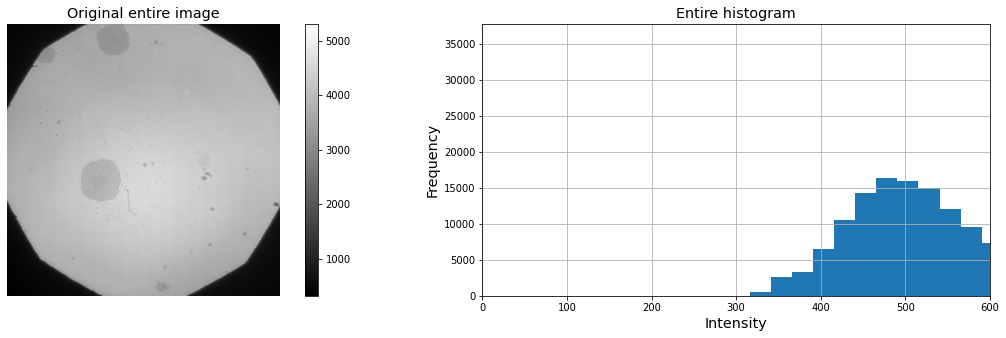

In [3]:
# Read the RICM image
RICM_img = io.imread(f"Data/{experiment}/data/AVG_vesicle_{shot}_MMStack_Default.ome.tif")

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image', fontsize='x-large')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram', fontsize='x-large')
plt.hist(RICM_img.ravel(), bins = 200)
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.xlim(0,600)
plt.grid();

### Read the GUV image and subtract the base line

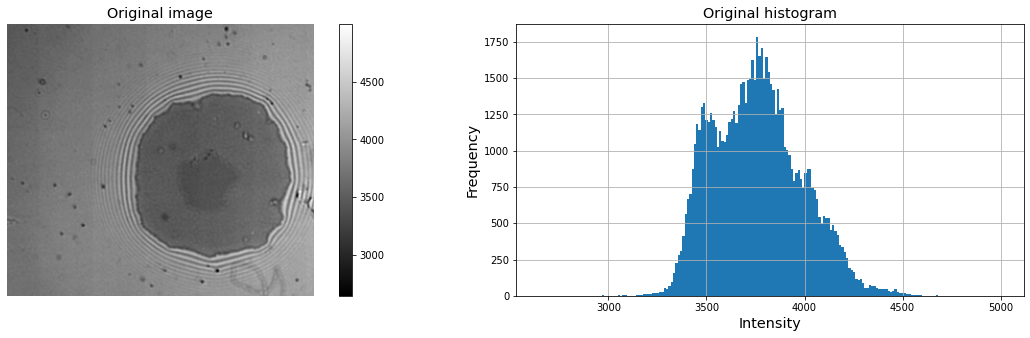

In [4]:
# Read the GUV image
img = io.imread(f"Data/{experiment}/data/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}.tif")

# Subtract the base line
img = img - 310

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original image', fontsize='x-large')
plt.imshow(img, cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.title('Original histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.hist(img.ravel(), bins = 200)
#plt.xlim(70,87)
plt.grid();

### Define the RICM model

Y0 = 0.01, A = 0.24, h0 = 32.11


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:251: RuntimeWarning: invalid value encountered in arccos
  return (self.l / (4 * np.pi * self.n_outer)) * np.arccos((Y0 - img_background_normalized) / A) + h0


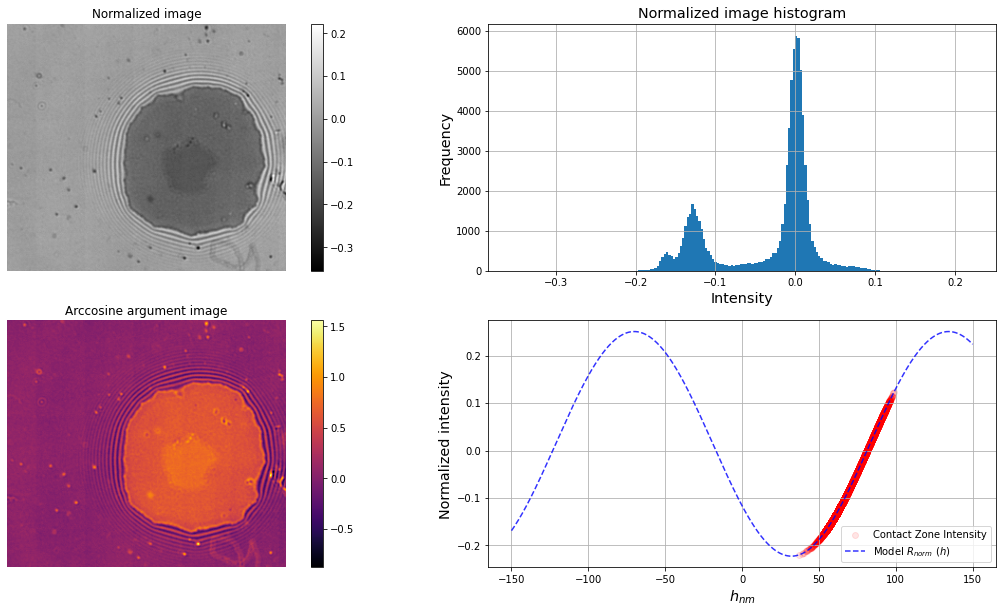

In [5]:
h = np.linspace(-150, 150, 600)

# Define the RICM class with certain n_inner
ricm = RICM(img, n_inner = 1.344, hole = 3)

# define the Normalized intensity, heghiet
I_norm = ricm.background_normalization()
Height = ricm.height(h)
Mask = ricm.mask()

# Get the intensity vs height on the contact zone                    
I_norm_img = []
h_img = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if Mask[i,j] == 1:     # only the contact zone
            I_norm_img.append(I_norm[i,j])
            h_img.append(Height[i,j])


# Normalized image 
plt.figure(figsize=(20,10))

# Normalized image
plt.subplot(221)
plt.axis('off')
plt.title('Normalized image')
plt.imshow(ricm.background_normalization(), cmap = "gray")
plt.colorbar()

# The histogram of the normalized image
plt.subplot(222)
plt.title('Normalized image histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.hist(ricm.background_normalization().ravel(), bins = 200)
plt.grid()

# Show the argument of the arccosine to make sure it's between 1 and -1
plt.subplot(223)
plt.axis('off')
plt.title('Arccosine argument image')
plt.imshow(ricm.height_argument() , cmap = 'inferno')
plt.colorbar()

plt.subplot(224)
plt.scatter(h_img, I_norm_img, color = 'r', label = "Contact Zone Intensity", alpha = 0.1)
plt.plot(h, ricm.R5_norm(h), 'b--', label = "Model $R_{norm}\ (h)$", alpha = 0.8)
#plt.title("$R_{norm}$ for different $h$ and $n_{inner} = 1.34$ ", fontsize='x-large')
plt.xlabel("$h_{nm}$", fontsize='x-large')
plt.ylabel("Normalized intensity", fontsize='x-large')
plt.legend()
plt.grid()

### Display the height image and it's histogram

Y0 = 0.01, A = 0.24, h0 = 32.11
The height of the GUV is 62.42 nm


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:251: RuntimeWarning: invalid value encountered in arccos
  return (self.l / (4 * np.pi * self.n_outer)) * np.arccos((Y0 - img_background_normalized) / A) + h0


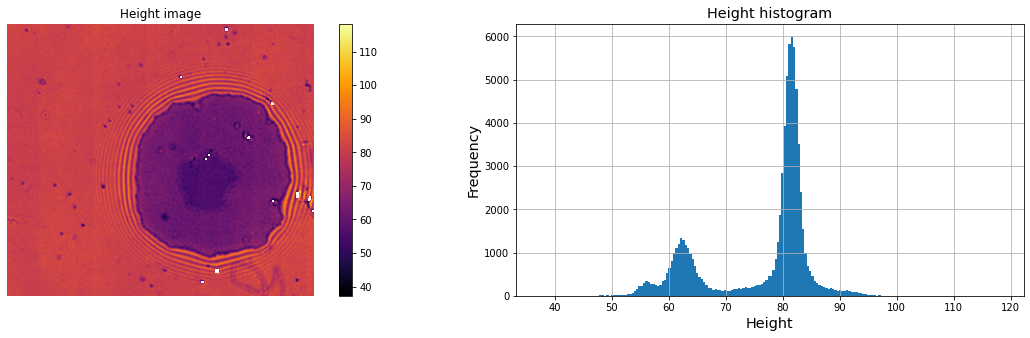

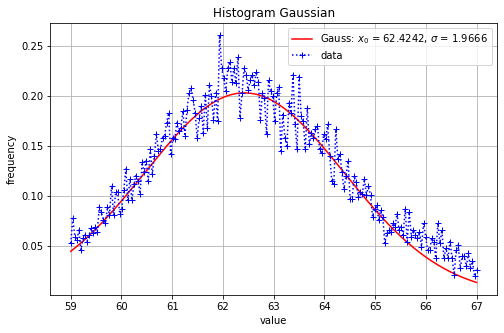

In [6]:
img_height = ricm.height()

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axis('off')
plt.title('Height image')
plt.imshow(img_height, cmap = "inferno")
plt.colorbar();

plt.subplot(122)
plt.title('Height histogram', fontsize='x-large')
plt.xlabel('Height', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.hist(img_height.ravel(), bins = 200)
#plt.xlim(70,87)
plt.grid();

# Cut the peak of the adhesion zone
adhesion = []
for i in img_height.ravel():
    if i > 59 and i < 67 :
        adhesion.append(i)
        
# Fit a gaussian on the adhesion zone histogram
gauss = Fit_Gaussian(adhesion, normalized=True)
height, _ = gauss.hist_fitting(show = True)

# Print the height in nano meter
print(f'The height of the GUV is {height:.2f} nm')

### Save the images in tif format

In [7]:
# Create the results directory
os.mkdir(f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm')

# Save the results
Image.fromarray(img).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/original.tif')
Image.fromarray(ricm.nl_denoise()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/nl_denoise.tif')
Image.fromarray(ricm.edge_detection()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/edge_detection.tif')
Image.fromarray(ricm.mask()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/mask.tif')
Image.fromarray(ricm.background_fitting()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/background_fitting.tif')
Image.fromarray(ricm.correct()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/correct.tif')
Image.fromarray(ricm.background_normalization()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/background_normalization.tif')
Image.fromarray(ricm.height()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/height.tif')

Y0 = 0.01, A = 0.24, h0 = 32.11


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:251: RuntimeWarning: invalid value encountered in arccos
  return (self.l / (4 * np.pi * self.n_outer)) * np.arccos((Y0 - img_background_normalized) / A) + h0


### Display the way to the RICM height mapping step by step

Y0 = 0.01, A = 0.24, h0 = 32.11


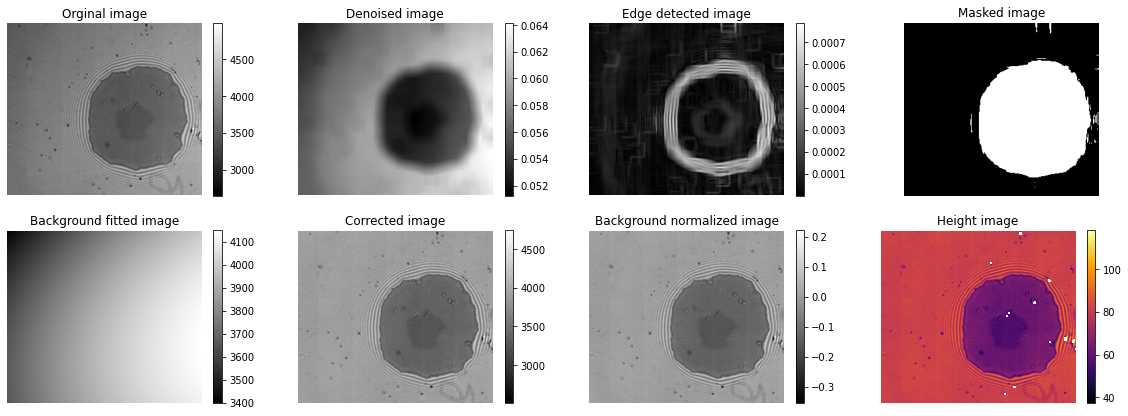

In [8]:
# display results
plt.figure(figsize=(20,7))

plt.subplot(241)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(img, cmap = "gray")
plt.colorbar()

plt.subplot(242)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(243)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar();

plt.subplot(244)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(245)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar();

plt.subplot(246)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar()

plt.subplot(247)
plt.axis('off')
plt.title('Background normalized image')
plt.imshow(ricm.background_normalization() , cmap = 'gray')
plt.colorbar()

plt.subplot(248)
plt.axis('off')
plt.title('Height image')
plt.imshow(ricm.height() , cmap = 'inferno')
plt.colorbar();

# Save the image
#plt.savefig('Background subtracted image')

# Show the results
plt.show()